In [1]:
import sys
#!{sys.executable} -m pip install xgboost

In [2]:
import time
import os # For
import pandas as pd
import numpy as np
import json  
import zipfile
#***** Start ANOVA-relaterte moduler
import statsmodels.api as sm
from statsmodels.formula.api import ols
#***** SluttANOVA-relaterte moduler
#****** Start moduler for å lage figurer
from plotnine import *
from plotnine.options import figure_size
from mizani.formatters import percent_format
#****** Slutt moduler for å lage figurer
#******** Start moduler for å utvikle og evaluere prediksjonsmodell
from itertools import chain, combinations
import random
import xgboost as xgb 

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
#******** Slutt moduler for å utvikle og evaluere prediksjonsmodell

In [3]:
def clean_data(df,meta_dict):
    #
    for var in list(df.columns):
        meta_type = meta_dict['properties'][var]['type']
        cast_func = None
        if meta_type =='string':
            cast_func = str
        elif meta_type == 'integer':
            cast_func = int
        elif meta_type == 'number':
            cast_func = float
        #        
        if cast_func is not None:
            df[var] = df[var].map(lambda x: cast_func(x))               
    #
    return df 
#
def convertJSON2Frame(jsonPath):
    meta_dict = None
    df = None
    d = None  # Contains "dictionary data"
    data = None 
    with zipfile.ZipFile(jsonPath, "r") as z:
        for filename in z.namelist():  
            with z.open(filename) as f: 
                data = f.read()  
                d = json.loads(data.decode("utf-8"))
                if meta_dict is None:
                    meta_dict = d
                else:
                    #Convert dictionary to dataframe
                    next_frame = pd.DataFrame.from_dict(d,orient="index").transpose()
                    if df is None:        
                        df  = next_frame
                    else:
                        df = pd.concat([df,next_frame])
    #
    df = clean_data(df,meta_dict)
    return df,meta_dict
# 

In [4]:
jsonPath = '../../Data/data_science_case_data.zip'
before_read = time.time()
df,meta_dict = convertJSON2Frame(jsonPath)
after_read = time.time()
print(f'Innlesing av data tok {str(after_read-before_read)} sekunder.')

Innlesing av data tok 1.8691937923431396 sekunder.


# Datakvalitet

- Struktur

In [5]:
print(meta_dict)

{'title': 'SensorData', 'description': 'Data model that contains sensor data entries', 'type': 'object', 'properties': {'timestamp': {'title': 'Timestamp', 'description': 'The timestamp associated with the recorded entry', 'type': 'string'}, 'event_id': {'title': 'Event Id', 'description': 'A UUID associated with the recorded event', 'type': 'string'}, 'train_id': {'title': 'Train Id', 'description': 'An identifier associated with the train', 'type': 'integer'}, 'incident': {'title': 'Incident', 'description': 'Whether an incident has occurred (1) or not (0)', 'default': 0, 'type': 'integer'}, 'kontaktkraft': {'title': 'Kontaktkraft', 'description': 'The contact pressure at the time of the data entry', 'type': 'number'}, 'hastighet': {'title': 'Hastighet', 'description': 'Speed at which the train is driving at the time of the data entry', 'type': 'number'}, 'location_type': {'title': 'Location Type', 'description': 'The type of location at which the train is driving (e.g. bridge, regul

In [6]:
print(df.shape)
print(df.info())

(2000, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 0 to 0
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   timestamp         2000 non-null   object 
 1   event_id          2000 non-null   object 
 2   train_id          2000 non-null   int64  
 3   incident          2000 non-null   int64  
 4   kontaktkraft      2000 non-null   float64
 5   hastighet         2000 non-null   float64
 6   location_type     2000 non-null   object 
 7   wind_speed        2000 non-null   float64
 8   wind_direction    2000 non-null   float64
 9   distance_to_pole  2000 non-null   float64
dtypes: float64(5), int64(2), object(3)
memory usage: 171.9+ KB
None


In [7]:
print(" \nCount total NaN at each column in a DataFrame : \n\n",
      df.isnull().sum())

 
Count total NaN at each column in a DataFrame : 

 timestamp           0
event_id            0
train_id            0
incident            0
kontaktkraft        0
hastighet           0
location_type       0
wind_speed          0
wind_direction      0
distance_to_pole    0
dtype: int64


# Konsistens og riktighet til dataene 


In [8]:
print(f"Tidligste obsersvasjonstidspunkt er {df['timestamp'].min()} og seneste er  {df['timestamp'].max()} ")

Tidligste obsersvasjonstidspunkt er 2023-06-11T19:21:23.033373 og seneste er  2023-06-11T19:21:23.590536 


In [9]:
#print(df['timestamp'].unique())
print(sorted(df['timestamp'].unique().tolist()))

['2023-06-11T19:21:23.033373', '2023-06-11T19:21:23.038519', '2023-06-11T19:21:23.039178', '2023-06-11T19:21:23.041322', '2023-06-11T19:21:23.043666', '2023-06-11T19:21:23.051550', '2023-06-11T19:21:23.054331', '2023-06-11T19:21:23.055037', '2023-06-11T19:21:23.055537', '2023-06-11T19:21:23.062258', '2023-06-11T19:21:23.062366', '2023-06-11T19:21:23.064387', '2023-06-11T19:21:23.064525', '2023-06-11T19:21:23.072031', '2023-06-11T19:21:23.072529', '2023-06-11T19:21:23.073029', '2023-06-11T19:21:23.073528', '2023-06-11T19:21:23.074032', '2023-06-11T19:21:23.074528', '2023-06-11T19:21:23.082929', '2023-06-11T19:21:23.088880', '2023-06-11T19:21:23.089379', '2023-06-11T19:21:23.093695', '2023-06-11T19:21:23.096927', '2023-06-11T19:21:23.099096', '2023-06-11T19:21:23.122259', '2023-06-11T19:21:23.129752', '2023-06-11T19:21:23.131893', '2023-06-11T19:21:23.140019', '2023-06-11T19:21:23.142182', '2023-06-11T19:21:23.150281', '2023-06-11T19:21:23.150370', '2023-06-11T19:21:23.152523', '2023-06-

In [10]:
example_variables = ['timestamp','train_id','location_type','distance_to_pole']
print(df.query("train_id == 0 and timestamp == '2023-06-11T19:21:23.043666'")[example_variables])

                    timestamp  train_id   location_type  distance_to_pole
0  2023-06-11T19:21:23.043666         0  open_landscape         23.198393
0  2023-06-11T19:21:23.043666         0  open_landscape          1.283947
0  2023-06-11T19:21:23.043666         0  open_landscape          1.386633
0  2023-06-11T19:21:23.043666         0  open_landscape         23.450976
0  2023-06-11T19:21:23.043666         0  open_landscape         12.233565
0  2023-06-11T19:21:23.043666         0  open_landscape         23.269972
0  2023-06-11T19:21:23.043666         0            town         21.081060
0  2023-06-11T19:21:23.043666         0        mountain          1.011585
0  2023-06-11T19:21:23.043666         0  open_landscape         11.256726
0  2023-06-11T19:21:23.043666         0            town         21.495514
0  2023-06-11T19:21:23.043666         0  open_landscape         12.243882
0  2023-06-11T19:21:23.043666         0            town          1.405239
0  2023-06-11T19:21:23.043666         

### Litt mer om konsistens

In [11]:
df[['train_id','wind_direction']].drop_duplicates().sort_values(by='train_id')

,train_id,wind_direction
0,0,180.0
0,1,0.0
0,2,225.0
0,3,0.0
0,4,270.0
0,5,270.0
0,6,0.0
0,7,135.0
0,8,45.0
0,9,180.0


In [12]:
wind_model = ols('wind_speed ~ C(train_id) + C(location_type)', data=df).fit() 
print(sm.stats.anova_lm(wind_model, typ=2))

                        sum_sq      df              F    PR(>F)
C(train_id)       80935.045985     9.0  117033.386992  0.000000
C(location_type)      0.252945     4.0       0.822967  0.510392
Residual            152.603178  1986.0            NaN       NaN


### Start kode for tilpasse og evaluere xgboost-prediksjonsmodell av 'incident' v.h.a. variablene 'kontaktkraft' og 'hastighet'

In [13]:
def set_params(model_variables,increasing=[],decreasing=[],params={}):
    # Setter først defaultverdier
    if len(params) == 0:
        params = {
            'objective': "binary:logistic",
            'eval_metric': 'logloss',
            'lambda': 10000,
            # 'n_estimators': 1000
        }
    # Bare legg til monotonicity constraints hvis det faktisk er noen variabler som skal ha slike constraints
    if(len(set(increasing).intersection(model_variables)) > 0 or
           len(set(decreasing).intersection(model_variables)) > 0):
        #
        constraints_dict = {}
        for feature in model_variables:
            constr_value = 0  # Tilsvarere ingen monotonitetskrav
            if feature in decreasing:
                constr_value = -1  # Monotonitetskrav synkende
            elif feature in increasing:  # Monotonitetskrav stigende
                constr_value = 1
            #
            constraints_dict[feature] = constr_value
        #
        constraints_list = [constraints_dict[feature] for feature in model_variables]
        params['monotone_constraints'] = str(tuple(constraints_list))
    #
    return(params)
# Mer info om "powerset" https://stackoverflow.com/questions/18035595/powersets-in-python-using-itertools
def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
#
def xgb_cv_predict(X,y,params,cv=5):
    # Forste steg er å dele X og y inn i "k-folds".
    kfold = [random.randint(0, cv-1) for iter in range(X.shape[0])]
    predictions = [None]*X.shape[0]
    #
    for fold in range(cv):
        fit_rows = [ind for ind in range(X.shape[0]) if kfold[ind] != fold]
        pred_rows = [ind for ind in range(X.shape[0]) if kfold[ind] == fold]
        X_fit_fold = X.iloc[fit_rows,:]
        y_fit_fold = y.iloc[fit_rows]
        #
        X_pred_fold = X.iloc[pred_rows,:]
        #
        xgb_fit_data = xgb.DMatrix(X_fit_fold, y_fit_fold)
        xgb_score_data = xgb.DMatrix(X_pred_fold)
        #
        fold_model = xgb.train(params=params,
                                 dtrain=xgb_fit_data,
                                 num_boost_round=1000,
                                 early_stopping_rounds=10,
                                 evals=[(xgb_fit_data, 'train')],
                                 verbose_eval=False)
        #
        fold_predictions = fold_model.predict(data=xgb_score_data)
        # Lagrer prediksjonene
        for ind, row in enumerate(pred_rows):
            predictions[row] = fold_predictions[ind]
        #
    return predictions
#
def binary_LL(target,predict):
    # Hjelpefunksjon for å regne ut log likelihood ved binære utfall (to mulige utfall)
    ## Assumet that the input is two lists
    ll_frame = pd.DataFrame({'target': target, 'predict': predict})
    ll_frame['likelihood'] = ll_frame.apply(
        lambda x: x.predict if x.target == 1 else (1-x.predict if x.target == 0 else None),
        axis=1)
    #
    ll_frame['ll'] = ll_frame['likelihood'].map(lambda x: np.log(x) if x is not None else x)
    ll = sum(ll_frame['ll'])
    return ll
#
def scoregroup_count(target, predict, ngroups=5):
    sorted_target_predict = pd.DataFrame({"target":target,'predict':predict}).sort_values(
        by="predict",ascending = False)
    #
    sorted_target_predict['Scoregroup'] = np.ceil(
        [ngroups*i/sorted_target_predict.shape[0] for i in list(range(1,sorted_target_predict.shape[0]+1))])
    #
    '''
    Since the scoregroups are going to be used as groups for a groupby it is more convenient 
    if they are  integers
    '''
    sorted_target_predict['Scoregroup'] = sorted_target_predict['Scoregroup'].astype({"Scoregroup": int})
    scoregroup_stats = pd.DataFrame({'Scoregroup': list(range(1,ngroups+1))})
    gb = sorted_target_predict.groupby(['Scoregroup'])
    counts = gb.size().to_frame(name='counts')
    #
    target_sum_name = 'number_of_incidents'
    #
    scoregroup_stats = (counts.join(gb.agg({"target": 'sum'}).rename(columns={"target": target_sum_name}))
                       .join(gb.agg({"target": 'mean'}).rename(columns={"target": 'proportion_incidents'}))
                       .join(gb.agg({"predict": 'min'}).rename(columns={"predict": 'min_predict'}))
                       .join(gb.agg({"predict": 'max'}).rename(columns={"predict": 'max_predict'}))
                        .join(gb.agg({"predict": 'mean'}).rename(columns={"predict": 'mean_predict'}))
                       .reset_index())
    #
    scoregroup_stats = scoregroup_stats.assign(cum_share_of_test_group=scoregroup_stats['counts'].cumsum() /
                                               scoregroup_stats['counts'].sum(),
                                               cum_share_of_incidents=scoregroup_stats[target_sum_name].cumsum() /
                                               scoregroup_stats[target_sum_name].sum())
    #
    return(scoregroup_stats)
#
def exhaustive_search(df,response_variable,candidate_variables,default_selection=[],ngroups=5):
    uncertain_variables = list(set(candidate_variables).difference(set(default_selection)))
    variable_choices = list(powerset(uncertain_variables))
    # Remove any entry with no variables (if present)
    variable_choices.remove(())
    list_of_choices = []
    auc_scores = []
    ll_scores = []
    AIC_scores = []
    BIC_scores = []
    #
    sgc_dict = {}
    #
    for iter_nr, choice in enumerate(variable_choices):
        current_selection = list(set(default_selection).union(set(list(choice))))
        X = df[current_selection]
        y = df[response_variable]
        list_of_choices.append(current_selection)
        params = set_params(current_selection)
        y_pred = xgb_cv_predict(X, y, params, cv=5)
        #
        ll_score = binary_LL(y.tolist(), y_pred)
        ll_scores.append(ll_score)
        AIC_score = 2*len(current_selection)-ll_score
        AIC_scores.append(AIC_score)
        BIC_score = len(current_selection)*np.log(len(y.tolist()))-2*ll_score
        BIC_scores.append(BIC_score)
        sgc_dict[str(current_selection)] =  scoregroup_count(df[response_variable], y_pred, ngroups=ngroups)
        #
        auc_score = roc_auc_score(y.tolist(), y_pred)
        auc_scores.append(auc_score)
    #
    new_eval_frame = pd.DataFrame({'var_choice': list_of_choices, 'auc': auc_scores,'ll': ll_scores, 'AIC': AIC_scores, 'BIC': BIC_scores})
    new_eval_frame['number_of_features'] = new_eval_frame['var_choice'].map(lambda x: len(x))
    #sorted_new_eval_frame = new_eval_frame.sort_values(by='auc', ascending=False)
    # OBSSSSS BIC skal minimeres, ikke maksimeres
    sorted_new_eval_frame = new_eval_frame.sort_values(by='BIC', ascending=True)
    return sorted_new_eval_frame,sgc_dict


#### Utforskning for valg av modell

In [27]:
print('Skal nå forsøke å kjøre exhaustive_search')
firstTrain = df.query('train_id==0').sort_values(by='timestamp')
before_exhaustive = time.time()
response_variable = 'incident'
sorted_new_eval_frame,sgc_dict = exhaustive_search(
    df=firstTrain,
    response_variable = response_variable,
    candidate_variables = ['kontaktkraft','distance_to_pole','hastighet'],
    default_selection=['kontaktkraft'],
    ngroups=5
)
after_exhaustive = time.time()
#
print(f'Exhaustive search tok {str(after_exhaustive-before_exhaustive)} sekunder')
print(sorted_new_eval_frame)

Skal nå forsøke å kjøre exhaustive_search
Exhaustive search tok 38.212870836257935 sekunder
                                    var_choice       auc         ll   
0                    [hastighet, kontaktkraft]  0.979185 -68.334006  \
1             [distance_to_pole, kontaktkraft]  0.967962 -69.157640   
2  [hastighet, distance_to_pole, kontaktkraft]  0.971473 -68.704822   

         AIC         BIC  number_of_features  
0  72.334006  147.264647                   2  
1  73.157640  148.911916                   2  
2  74.704822  153.304596                   3  


In [15]:
sorted_new_eval_frame

,var_choice,auc,ll,AIC,BIC,number_of_features
0,"[hastighet, kontaktkraft]",0.985956,-68.077250,72.077250,146.751134,2
1,"[distance_to_pole, kontaktkraft]",0.977868,-68.451362,72.451362,147.499359,2
2,"[hastighet, distance_to_pole, kontaktkraft]",0.993793,-67.746252,73.746252,151.387456,3


In [16]:
for item,value in sgc_dict.items():
    print(f'Variabelkombinasjon {item} har scoregruppetellinger')
    print(value)

Variabelkombinasjon ['hastighet', 'kontaktkraft'] har scoregruppetellinger
   Scoregroup  counts  number_of_incidents  proportion_incidents  min_predict   
0           1      40                   39                 0.975     0.609960  \
1           2      40                   15                 0.375     0.243452   
2           3      40                    1                 0.025     0.238536   
3           4      40                    0                 0.000     0.234387   
4           5      40                    0                 0.000     0.231902   

   max_predict  mean_predict  cum_share_of_test_group  cum_share_of_incidents  
0     0.643606      0.629962                      0.2                0.709091  
1     0.609960      0.396470                      0.4                0.981818  
2     0.243452      0.239765                      0.6                1.000000  
3     0.238536      0.236598                      0.8                1.000000  
4     0.234387      0.232896          

In [17]:
response_variable = 'incident'
model_features = ['kontaktkraft','hastighet','distance_to_pole']
#
train_data = df.query('train_id >= 1 and train_id  <=5')
test_data = df.query('train_id > 5')

In [18]:
params = set_params(model_features)
xgb_train_data = xgb.DMatrix(train_data[model_features], train_data[response_variable])
xgb_test_data = xgb.DMatrix(test_data[model_features])
#
validation_model = xgb.train(params=params,
                       dtrain=xgb_train_data,
                       num_boost_round=1000,
                       early_stopping_rounds=10,
                       evals=[(xgb_train_data, 'train')],
                       verbose_eval=20)

[0]	train-logloss:0.68731
[20]	train-logloss:0.58529
[40]	train-logloss:0.50637
[60]	train-logloss:0.44469
[80]	train-logloss:0.39587
[100]	train-logloss:0.35668
[120]	train-logloss:0.32477
[140]	train-logloss:0.29846
[160]	train-logloss:0.27646
[180]	train-logloss:0.25782
[200]	train-logloss:0.24186
[220]	train-logloss:0.22807
[240]	train-logloss:0.21604
[260]	train-logloss:0.20546
[280]	train-logloss:0.19610
[300]	train-logloss:0.18776
[320]	train-logloss:0.18028
[340]	train-logloss:0.17353
[360]	train-logloss:0.16742
[380]	train-logloss:0.16186
[400]	train-logloss:0.15677
[420]	train-logloss:0.15211
[440]	train-logloss:0.14781
[460]	train-logloss:0.14384
[480]	train-logloss:0.14015
[500]	train-logloss:0.13673
[520]	train-logloss:0.13354
[540]	train-logloss:0.13055
[560]	train-logloss:0.12775
[580]	train-logloss:0.12511
[600]	train-logloss:0.12262
[620]	train-logloss:0.12028
[640]	train-logloss:0.11806
[660]	train-logloss:0.11596
[680]	train-logloss:0.11397
[700]	train-logloss:0.1120

In [19]:
validation_importances = validation_model.get_score(importance_type='gain')
# Lager prediksjoner
test_predictions = validation_model.predict(data=xgb.DMatrix(test_data[model_features]))

In [20]:
print(validation_importances)

{'kontaktkraft': 0.14537902176380157}


In [21]:
#*************** Start evaluere
sgc_validation = scoregroup_count(test_data[response_variable], test_predictions, ngroups=10)
class_predictions = [round(x) for x in test_predictions]
accuracy = accuracy_score([str(x) for x in test_data[response_variable].to_list()], [str(x) for x in class_predictions])
false_negatives = [test_predictions[ind] for ind in range(len(test_predictions)) if test_data[response_variable].to_list()[ind] == 1 and test_predictions[ind] <0.5] 
false_positives = [test_predictions[ind] for ind in range(len(test_predictions)) if test_data[response_variable].to_list()[ind] == 0 and test_predictions[ind] >=0.5]
#
eval_auc_score = roc_auc_score(test_data[response_variable].tolist(), test_predictions)

In [22]:
print(f'accuracy er {accuracy}, antall falske negative er {len(false_negatives)} og antall falske positive er {len(false_positives)} ')

accuracy er 0.9975, antall falske negative er 0 og antall falske positive er 2 


In [23]:
df_group_train = df.groupby(['train_id'])
gb = df[['incident','train_id']].sort_values(by="train_id").groupby(['train_id'])
counts = df_group_train.size().to_frame(name='counts')  
response_variable = 'incident'
target_sum_name = 'number_of_incidents'
    #
train_id_stats = (counts.join(gb.agg({response_variable: 'sum'}).rename(columns={response_variable: target_sum_name}))
                       .join(gb.agg({response_variable: 'mean'}).rename(columns={response_variable: 'proportion_incidents'}))
                       .reset_index())   
train_id_stats['proportion_of_all_events'] =   train_id_stats['counts'].map(lambda x: x/df.shape[0])  
train_id_stats['proportion_of_all_incidents'] =   train_id_stats[target_sum_name].map(lambda x: x/df[response_variable].sum()) 
train_id_stats['cumulative_share_events'] =   train_id_stats['counts'].cumsum()/train_id_stats['counts'].sum()
train_id_stats.sort_values('proportion_incidents',inplace = True,ascending = False)
train_id_stats['cumulative_share_incidents'] =   train_id_stats['proportion_of_all_incidents'].cumsum()
#
train_id_stats['train_id_factor'] =  pd.Categorical(train_id_stats['train_id'],categories = train_id_stats['train_id'].to_list(),ordered=True)

In [24]:
var_name = "Counting_variable"
value_name = "Proportion"
#
plot_data = train_id_stats.melt(
    id_vars=['train_id_factor'],
    value_vars=["proportion_of_all_incidents","cumulative_share_incidents"],
    var_name = var_name,
    value_name = value_name,
    ignore_index = True
)

In [25]:
train_id_plot =  (ggplot(plot_data, aes(x="train_id_factor",y = value_name, fill = var_name))
                    + geom_bar(stat="identity",position = "dodge")
                    + scale_y_continuous(labels=percent_format())
                    + geom_text(
                        aes(label = value_name),
                          va = 'top',
                        format_string="{:.1%}",
                        size=30
                    )
                  + theme(
                      figure_size=(20, 10),
                      legend_title = element_text(size=30),
                      legend_text = element_text(size=20)
                  )
                )

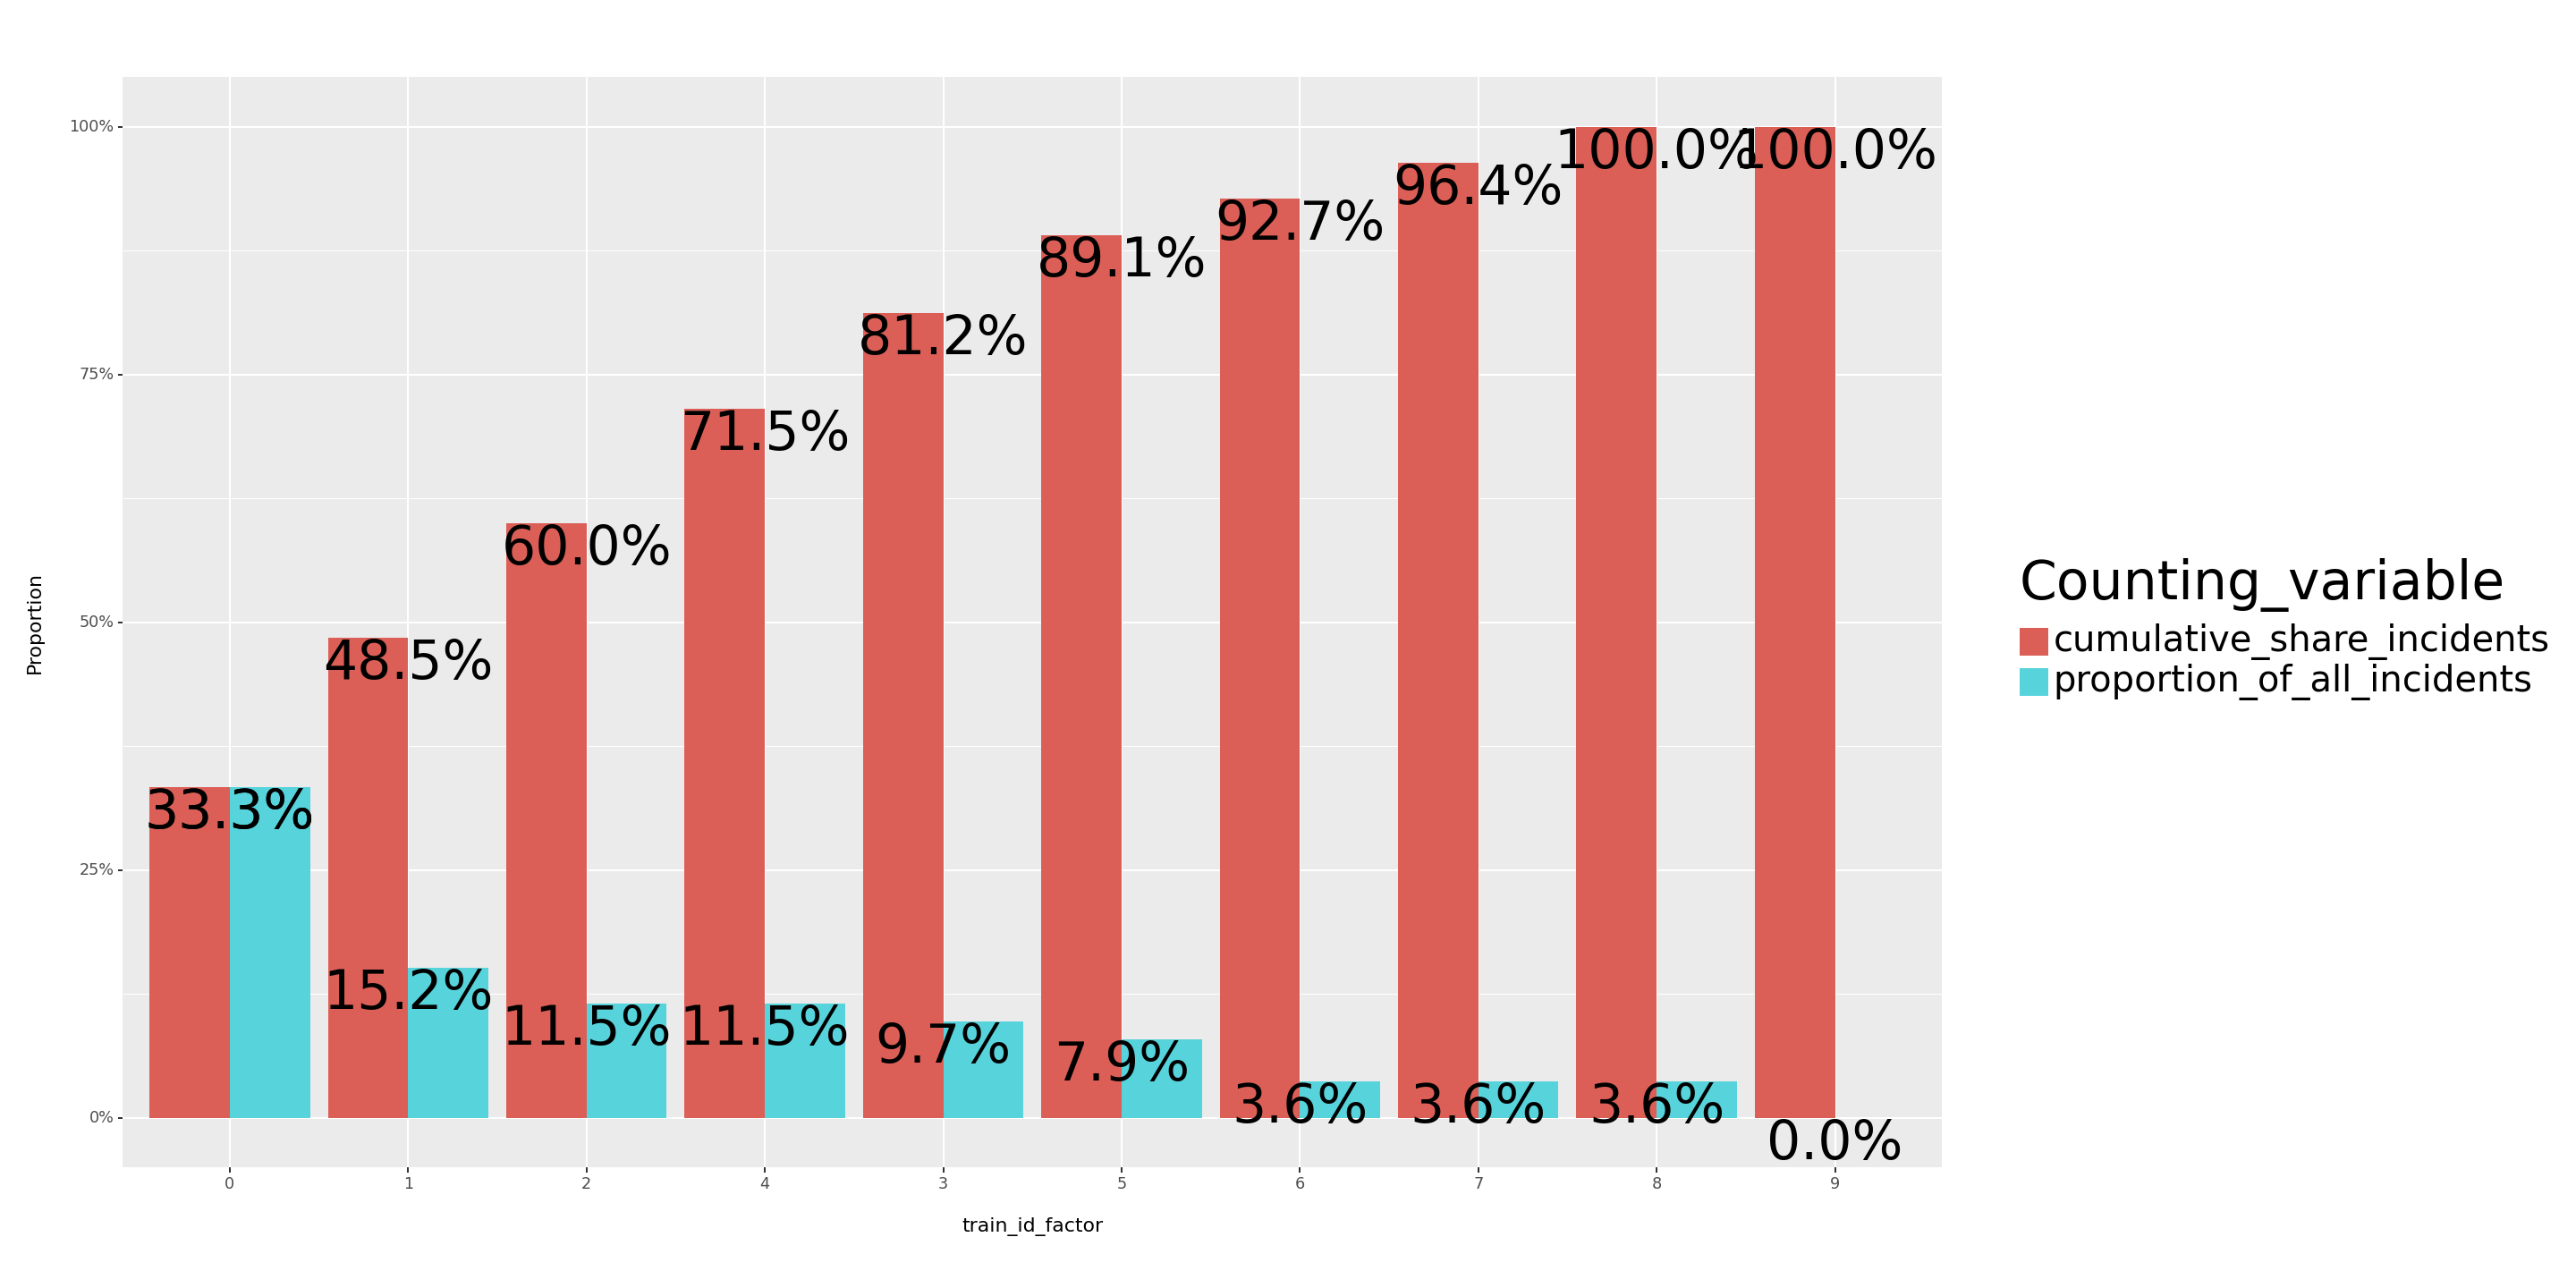

<Figure Size: (1440 x 720)>

In [26]:
train_id_plot